In [351]:
import json 
import os
import logging 
import concurrent 
import asyncio 
import re 
import requests 

from collections import deque 
from itertools import chain 
# from datetime import date, datetime 

from typing import List 
from pprint import PrettyPrinter

from subgrounds import Subgrounds
from palettable.tableau import Tableau_20
from palettable.mycarta import Cube1_4, Cube1_8
from subgrounds.pagination import ShallowStrategy

from web3 import Web3
from concurrent.futures import ThreadPoolExecutor

# apis / networking 
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
from etherscan import Etherscan
from pycoingecko import CoinGeckoAPI

import pandas as pd 
import numpy as np 
import altair as alt 
import missingno as miss
from IPython.display import HTML, display


from utils import (
    ddf, remove_prefix, query_attrs, camel_to_snake, df_cols_camel_to_snake, df_cols_change_prefix
)

# logging.basicConfig(level=logging.INFO)

VALIDATE = True  

pp = PrettyPrinter().pprint

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [352]:
colors_24 = Tableau_20.hex_colors + Cube1_4.hex_colors
colors_28 = Tableau_20.hex_colors + Cube1_8.hex_colors

In [353]:
URL_INFURA = 'https://mainnet.infura.io/v3/856c3834f317452a82e25bb06e04de18'
w3 = Web3(Web3.HTTPProvider(URL_INFURA))
cg = CoinGeckoAPI()
hmmmm = 'VR7YA9DRDB4Y15B5N3WU9E7PSJ9RWPCP5S'
etherscan = Etherscan(hmmmm)

In [354]:
URL_CURVE_POOLS = 'https://api.thegraph.com/subgraphs/name/convex-community/curve-pools'
URL_CURVE_DAO = 'https://api.thegraph.com/subgraphs/name/convex-community/curve-dao'

# Tokens 
ADDRESS_frxETHCRV = '0xf43211935c781d5ca1a41d2041f397b8a7366c7a'.lower()
ADDRESS_frxETHCRV_GAUGE_DEPOSIT = '0x2932a86df44fe8d2a706d8e9c5d51c24883423f5'.lower()

# Contracts 
ADDRESS_CONVEX_VOTER_PROXY = '0x989aeb4d175e16225e39e87d0d97a3360524ad80'.lower()
ADDRESS_CURVE_POOL_FRXETH_ETH = '0xa1f8a6807c402e4a15ef4eba36528a3fed24e577'.lower()
ADDRESS_FRAX_FARM_stkcvxfrxETHETH = '0xa537d64881b84faffb9Ae43c951EEbF368b71cdA'.lower()
ADDRESS_CONVEX_STAKING_WRAPPER_FRAX = '0x4659d5fF63A1E1EDD6D5DD9CC315e063c95947d0'.lower() 

# Analysis of Holders of frxETHCRV 

frxETHCRV is the liquidity pool token for the [frxETH:ETH pool](https://curve.fi/#/ethereum/pools/frxeth/deposit) on curve. 

Tracking which users hold frxETHCRV is not as simple as checking the total amount of this token across user accounts. 
There are various platforms where users can stake frxETHCRV in exchange for derivative tokens. This hierarchical outline
shows the various places where the supply of frxETHCRV exists within the ecosystem. 

**Contracts**: 
- Curve 
    - [frxETH:ETH curve pool](https://curve.fi/#/ethereum/pools/frxeth/deposit)
- Convex 
    - [Booster](https://docs.convexfinance.com/convexfinanceintegration/booster)
        - The curve deposit contract for curve LP tokens. 
        - User receives a deposit receipt token prefixed with "cvx". 
    - [BaseRewardPool](https://docs.convexfinance.com/convexfinanceintegration/baserewardpool)
        - The main reward contract for all LP pools.
        - User does not receive a deposit / staking token, simply updates an internal balance. 
    - [StakingWrapperFrax](https://etherscan.io/address/0x4659d5fF63A1E1EDD6D5DD9CC315e063c95947d0)
        - The frax deposit contract for curve LP tokens. 
 

**Tokens** 
- [frxETHCRV](https://etherscan.io/token/0xf43211935c781d5ca1a41d2041f397b8a7366c7a)
- [cvxfrxETHCRV](https://etherscan.io/token/0xC07e540DbFecCF7431EA2478Eb28A03918c1C30E)
- [stkcvxfrxETHCRV-frax](https://etherscan.io/token/0x4659d5ff63a1e1edd6d5dd9cc315e063c95947d0)

**Supply Breakdown**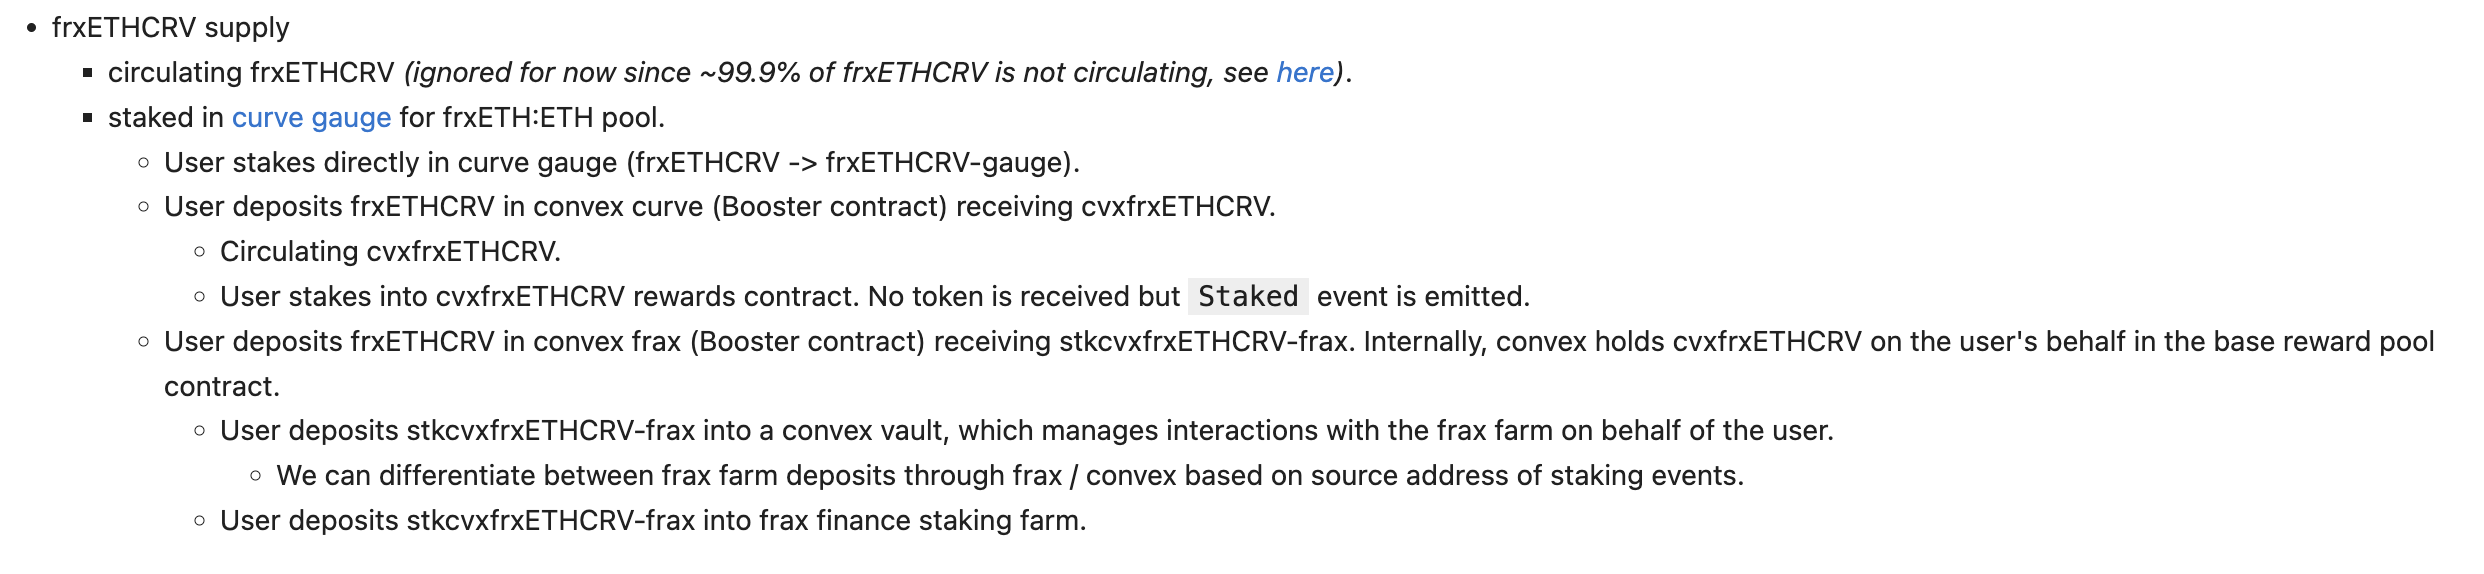
- frxETHCRV supply 
    - circulating frxETHCRV *(ignored for now since ~99.9% of frxETHCRV is not circulating, see [here](https://etherscan.io/token/0xf43211935c781d5ca1a41d2041f397b8a7366c7a#balances))*. 
    - staked in [curve gauge](0x2932a86df44fe8d2a706d8e9c5d51c24883423f5) for frxETH:ETH pool. 
        - User stakes directly in curve gauge (frxETHCRV -> frxETHCRV-gauge). 
        - User deposits frxETHCRV in convex curve (Booster contract) receiving cvxfrxETHCRV. 
            - Circulating cvxfrxETHCRV. 
            - User stakes into cvxfrxETHCRV rewards contract. No token is received but `Staked` event is emitted.
        - User deposits frxETHCRV in convex frax (Booster contract) receiving stkcvxfrxETHCRV-frax. Internally, convex holds cvxfrxETHCRV on the user's behalf in the base reward pool contract. 
            - User deposits stkcvxfrxETHCRV-frax into a convex vault, which manages interactions with the frax farm on behalf of the user. 
                - We can differentiate between frax farm deposits through frax / convex based on source address of staking events. 
            - User deposits stkcvxfrxETHCRV-frax into frax finance staking farm. 

In [355]:
def verified_contract(address): 
    address = Web3.toChecksumAddress(address) 
    abi = etherscan.get_contract_abi(address) 
    contract = w3.eth.contract(address, abi=abi)
    return contract 
    
def get_account_balance_of_erc20(account, token_address): 
    account = Web3.toChecksumAddress(account) 
    contract = verified_contract(token_address) 
    balance = contract.functions.balanceOf(account).call()
    decimals = contract.functions.decimals().call()
    return balance / 10**decimals 

In [356]:
sg = Subgrounds()
sg_curve_pools = sg.load_subgraph(URL_CURVE_POOLS)
sg_curve_dao = sg.load_subgraph(URL_CURVE_DAO) 

In [357]:
def get_curve_gauge_balances(): 
    # frxETHCRV staked in curve gauge by account. frxETHCRV -> frxETHCRV-gauge at 1:1 ratio 
    # ---------------------------------------------------------------------------------------------------------------------
    qattrs = ['id', 'provider', 'value']
    # deposits into gauge 
    df_deposits = query_attrs(
        sg, sg_curve_dao.Query.gaugeDeposits(first=100000, where={'gauge': ADDRESS_frxETHCRV_GAUGE_DEPOSIT}), qattrs
    )
    df_deposits = remove_prefix(df_deposits, 'gaugeDeposits_') 
    # withdawals from gauge 
    df_withdraws = query_attrs(
        sg, sg_curve_dao.Query.gaugeWithdraws(first=100000, where={'gauge': ADDRESS_frxETHCRV_GAUGE_DEPOSIT}), qattrs
    )
    df_withdraws = remove_prefix(df_withdraws, 'gaugeWithdraws_') 
    df_withdraws.value *= -1
    # Current deposited amount per address within gauge 
    df_curve = pd.concat([df_deposits, df_withdraws])
    df_curve = df_curve.groupby('provider')['value'].sum().reset_index()
    df_curve = df_curve.loc[df_curve.value != 0].sort_values('value', ascending=False).reset_index(drop=True)
    df_curve['platform'] = 'curve-gauge'
    df_curve.value /= 1e18
    return df_curve 

def validate_curve_gauge_balances(df_curve): 
    frxethCRV_curve_gauge = df_curve.value.sum()
    frxethCRV_curve_gauge_actual = get_account_balance_of_erc20(ADDRESS_frxETHCRV_GAUGE_DEPOSIT, ADDRESS_frxETHCRV)

    frxethCRV_convex_staked = df_curve.loc[df_curve.provider == ADDRESS_CONVEX_VOTER_PROXY].value.sum()
    frxethCRV_convex_staked_actual = get_account_balance_of_erc20(ADDRESS_CONVEX_VOTER_PROXY, ADDRESS_frxETHCRV_GAUGE_DEPOSIT)

    # Manual validation of frxETHCRV staked in curve gauge 
    # https://etherscan.io/token/0xf43211935c781d5ca1a41d2041f397b8a7366c7a?a=0x2932a86df44fe8d2a706d8e9c5d51c24883423f5
    print(f"Number of frxETHCRV deposited in curve gauge:\n\tComputed: {frxethCRV_curve_gauge:>20}\n\tActual: {frxethCRV_curve_gauge_actual:>20}")
    if VALIDATE: 
        np.testing.assert_almost_equal(frxethCRV_curve_gauge_actual, frxethCRV_curve_gauge, decimal=10)

    # Manual validation of frxETHCRV-gauge (1:1 with frxETHCRV) staked in convex 
    # https://etherscan.io/token/0x2932a86df44fe8d2a706d8e9c5d51c24883423f5?a=0x989aeb4d175e16225e39e87d0d97a3360524ad80
    print(f"Number of frxETHCRV-gauge staked held by convex voter proxy:\n\tComputed: {frxethCRV_convex_staked:>20}\n\tActual: {frxethCRV_convex_staked_actual:>24}")
    if VALIDATE: 
        np.testing.assert_almost_equal(frxethCRV_convex_staked_actual, frxethCRV_convex_staked, decimal=10)

    print(f"Percent of frxETHCRV staked in curve gauge through convex: {frxethCRV_convex_staked / frxethCRV_curve_gauge:%}")
    df_curve.head()

In [358]:
df_curve = get_curve_gauge_balances()

In [359]:
validate_curve_gauge_balances(df_curve)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/eth_abi/codec.py:87: DeprecationWarning: abi.encode_abi() and abi.encode_abi_packed() are deprecated and will be removed in version 4.0.0 in favor of abi.encode() and abi.encode_packed(), respectively
  warnings.warn(
/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/eth_abi/codec.py:191: DeprecationWarning: abi.decode_abi() is deprecated and will be removed in version 4.0.0 in favor of abi.decode()
  warnings.warn(


Number of frxETHCRV deposited in curve gauge:
	Computed:   32025.885548254453
	Actual:    32025.88554825446
Number of frxETHCRV-gauge staked held by convex voter proxy:
	Computed:     31478.0097644452
	Actual:       31478.009764445203
Percent of frxETHCRV staked in curve gauge through convex: 98.289272%


In [360]:
def get_convex_staked_balances(): 
    # frxETHCRV staked in convex (curve system). frxETHCRV -> cvxfrxETHCRV at 1:1 ratio 
    # ---------------------------------------------------------------------------------------------------------------------
    qattrs = ['id', 'amount', 'timestamp', 'user.address']
    # deposits into the convex staking contract for curve lp tokens 
    q_deposits = sg_curve_pools.Query.deposits(first=100000, where={'poolid_': {'swap': ADDRESS_CURVE_POOL_FRXETH_ETH}})
    df_deposits = query_attrs(sg, q_deposits, qattrs)
    df_deposits = remove_prefix(df_deposits, 'deposits_') 
    # withdrawals from the convex staking contract for curve lp tokens 
    q_withdrawals = sg_curve_pools.Query.withdrawals(first=100000, where={'poolid_': {'swap': ADDRESS_CURVE_POOL_FRXETH_ETH}})
    df_withdrawals = query_attrs(sg, q_withdrawals, qattrs)
    df_withdrawals = remove_prefix(df_withdrawals, 'withdrawals_') 
    df_withdrawals.amount *= -1
    # current deposited amount per account in convex staking contract for curve lp tokens 
    df_convex = pd.concat([df_deposits, df_withdrawals])
    df_convex.amount /= 1e18
    df_convex['platform'] = 'convex-curve'
    df_convex = df_convex.rename(columns={'user_address': 'account'})
    df_convex.head()
    return df_convex 

def validate_convex_staked_balances(df_convex): 
    # Ensure that the holdings of frxETHCRV-gauge by the convex voter proxy address are the same (computed in two ways) 
    # 1. Curve dao subgraph - aggregating curve gauge deposits and withdraws by address (convex voter proxy is one of them). 
    # 2. Convex curve pools subgraph - aggregating convex gauge deposits and withdawals by address. 
    # These numbers should be really close but sometimes might differ due to subgraph indexing speed. 
    convex_frxethcrv_1 = df_curve.loc[df_curve.provider == ADDRESS_CONVEX_VOTER_PROXY]['value'].values.tolist()[0]
    convex_frxethcrv_2 = df_convex.amount.sum()
    print(f"Convex voter proxy frxETHCRV-gauge (curve dao subgraph): {convex_frxethcrv_1:>24}")
    print(f"Convex voter proxy frxETHCRV-gauge (convex curve pool subgraph): {convex_frxethcrv_2}")
    if VALIDATE: 
        np.testing.assert_almost_equal(convex_frxethcrv_1, convex_frxethcrv_2, 10)

In [361]:
df_convex = get_convex_staked_balances()

In [362]:
validate_convex_staked_balances(df_convex)

Convex voter proxy frxETHCRV-gauge (curve dao subgraph):         31478.0097644452
Convex voter proxy frxETHCRV-gauge (convex curve pool subgraph): 31478.009764445185


In [363]:
df_curve.head(1)

,provider,value,platform
0,0x989aeb4d175e16225e39e87d0d97a3360524ad80,31478.00976,curve-gauge


In [364]:
df_convex.head(1)

,id,amount,timestamp,account,platform
0,0x007562ec43ffc63894d5b30e812bd65858605829090a...,1.01942,1669427219,0x0f903834187d37ff29dc2d607dd9fb50eb36b2b5,convex-curve


In [365]:
# Replace the single row in the curve gauge table with all the rows in the convex gauge table. 
# ---------------------------------------------------------------------------------------------------------------------
df_curve_no_convex = df_curve.loc[df_curve.provider != ADDRESS_CONVEX_VOTER_PROXY]
assert len(df_curve_no_convex) + 1 == len(df_curve)
df = (
    pd.concat([
        df_curve_no_convex.rename(columns={'provider': 'account', 'value': 'amount'})[['account', 'amount', 'platform']], 
        df_convex[['account', 'amount', 'platform']]
    ])
    .groupby(['account', 'platform'])['amount'].sum().reset_index()
    .sort_values('amount', ascending=False).reset_index(drop=True) 
)
# This total should match the amount of frxETHCRV held by the curve gauge deposit 
# https://etherscan.io/token/0xf43211935c781d5ca1a41d2041f397b8a7366c7a?a=0x2932a86df44fe8d2a706d8e9c5d51c24883423f5
computed = df.amount.sum()
actual = get_account_balance_of_erc20(ADDRESS_frxETHCRV_GAUGE_DEPOSIT, ADDRESS_frxETHCRV) 
if VALIDATE: 
    np.testing.assert_almost_equal(actual, computed, decimal=10)
df.head()

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/eth_abi/codec.py:87: DeprecationWarning: abi.encode_abi() and abi.encode_abi_packed() are deprecated and will be removed in version 4.0.0 in favor of abi.encode() and abi.encode_packed(), respectively
  warnings.warn(
/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/eth_abi/codec.py:191: DeprecationWarning: abi.decode_abi() is deprecated and will be removed in version 4.0.0 in favor of abi.decode()
  warnings.warn(


,account,platform,amount
0,0x4659d5ff63a1e1edd6d5dd9cc315e063c95947d0,convex-curve,27774.98340
1,0x3cf54f3a1969be9916dad548f3c084331c4450b5,convex-curve,1558.84150
2,0xa1175a219dac539f2291377f77afd786d20e5882,convex-curve,612.77391
3,0xdb722dd612d35a12e718138e7296e6ca3531fb98,convex-curve,327.99419
4,0x10e3085127c9bd92ab325f8d1f65cdcec2436149,curve-gauge,199.87980


In [350]:
# frxETHCRV staked in convex (frax system). frxETHCRV -> stkcvxfrxETHETH
# ---------------------------------------------------------------------------------------------------------------------
# Get deposits and withdrawals from the convex frax staking wrapper. This is what users interact with 
# when depositing + staking on the convex website 
contract_convex_staking_wrapper_frax = verified_contract(ADDRESS_CONVEX_STAKING_WRAPPER_FRAX)
deposit_logs = contract_convex_staking_wrapper_frax.events.Deposited.getLogs(fromBlock=0)
withdrawal_logs = contract_convex_staking_wrapper_frax.events.Withdrawn.getLogs(fromBlock=0)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/eth_abi/codec.py:191: DeprecationWarning: abi.decode_abi() is deprecated and will be removed in version 4.0.0 in favor of abi.decode()
  warnings.warn(
/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/eth_abi/codec.py:164: DeprecationWarning: abi.decode_single() is deprecated and will be removed in version 4.0.0 in favor of abi.decode()
  warnings.warn(


In [ ]:
deposits = [{'account': d.args['_account'], 'amount': d.args['_amount'] / 1e18} for d in deposit_logs]
withdrawals = [{'account': d.args['_user'], 'amount': -d.args['_amount'] / 1e18} for d in withdrawal_logs]

df_cvx_staking_frx = pd.DataFrame(deposits + withdrawals).groupby('account')['amount'].sum().reset_index()
df_cvx_staking_frx = df_cvx_staking_frx.sort_values('amount', ascending=False).reset_index(drop=True)
df_cvx_staking_frx = df_cvx_staking_frx.loc[df_cvx_staking_frx.amount != 0]

In [ ]:
# Determine if this address represents a vault owned by some user 
abi_convex_staking_proxy = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[],"name":"FEE_DENOMINATOR","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"_rewardsAddress","type":"address"}],"name":"changeRewards","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"checkpointRewards","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"convexCurveBooster","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"convexDepositToken","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"crv","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"curveLpToken","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"cvx","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"earned","outputs":[{"internalType":"address[]","name":"token_addresses","type":"address[]"},{"internalType":"uint256[]","name":"total_earned","type":"uint256[]"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeRegistry","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"fxs","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"getReward","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bool","name":"_claim","type":"bool"},{"internalType":"address[]","name":"_rewardTokenList","type":"address[]"}],"name":"getReward","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bool","name":"_claim","type":"bool"}],"name":"getReward","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_owner","type":"address"},{"internalType":"address","name":"_stakingAddress","type":"address"},{"internalType":"address","name":"_stakingToken","type":"address"},{"internalType":"address","name":"_rewardsAddress","type":"address"}],"name":"initialize","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"},{"internalType":"uint256","name":"_addl_liq","type":"uint256"}],"name":"lockAdditional","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"},{"internalType":"uint256","name":"_addl_liq","type":"uint256"}],"name":"lockAdditionalConvexToken","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"},{"internalType":"uint256","name":"_addl_liq","type":"uint256"}],"name":"lockAdditionalCurveLp","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"},{"internalType":"uint256","name":"new_ending_ts","type":"uint256"}],"name":"lockLonger","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"poolRegistry","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"rewards","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"_proxy","type":"address"}],"name":"setVeFXSProxy","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_liquidity","type":"uint256"},{"internalType":"uint256","name":"_secs","type":"uint256"}],"name":"stakeLocked","outputs":[{"internalType":"bytes32","name":"kek_id","type":"bytes32"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_liquidity","type":"uint256"},{"internalType":"uint256","name":"_secs","type":"uint256"}],"name":"stakeLockedConvexToken","outputs":[{"internalType":"bytes32","name":"kek_id","type":"bytes32"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_liquidity","type":"uint256"},{"internalType":"uint256","name":"_secs","type":"uint256"}],"name":"stakeLockedCurveLp","outputs":[{"internalType":"bytes32","name":"kek_id","type":"bytes32"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"stakingAddress","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"stakingToken","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"usingProxy","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"vaultType","outputs":[{"internalType":"enum IProxyVault.VaultType","name":"","type":"uint8"}],"stateMutability":"pure","type":"function"},{"inputs":[],"name":"vaultVersion","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"pure","type":"function"},{"inputs":[],"name":"vefxsProxy","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"}],"name":"withdrawLocked","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"}],"name":"withdrawLockedAndUnwrap","outputs":[],"stateMutability":"nonpayable","type":"function"}]'
vault_owners = {}
for a in df_cvx_staking_frx.account.unique():
    a = Web3.toChecksumAddress(a) 
    is_vault = True if w3.eth.getCode(a) else False
    if is_vault: 
        contract = w3.eth.contract(a, abi=abi_convex_staking_proxy)
        owner = contract.functions.owner().call()
        vault_owners[a] = owner

In [ ]:
# Update table with vault info 
df_cvx_staking_frx['vault_address'] = df_cvx_staking_frx.account.apply(lambda a: a if a in vault_owners else None)
mask_vault = ~df_cvx_staking_frx.vault_address.isna()
df_cvx_staking_frx.loc[mask_vault, 'account'] = df_cvx_staking_frx.loc[mask_vault].account.apply(lambda a: vault_owners[a])
assert all(df_cvx_staking_frx.loc[mask_vault].account != df_cvx_staking_frx.loc[mask_vault].vault_address)

# Add in platform information 
df_cvx_staking_frx['platform'] = 'convex-frax-no-vault'
df_cvx_staking_frx.loc[~df_cvx_staking_frx.vault_address.isna(), 'platform'] = 'convex-frax-vault'
df_cvx_staking_frx.tail()

In [ ]:
stake_vault = df_cvx_staking_frx.loc[~df_cvx_staking_frx.vault_address.isna()].amount.sum()
stake_no_vault = df_cvx_staking_frx.loc[df_cvx_staking_frx.vault_address.isna()].amount.sum()
print(f"Convex vault staking of stkfrxethCRV-frax: {stake_vault}")
print(f"Convex non-vault staking of stkfrxethCRV-frax: {stake_no_vault}")
print(f"Total: {stake_no_vault + stake_vault}")

In [367]:
contract_frax_farm = w3.eth.contract(
    Web3.toChecksumAddress(ADDRESS_FRAX_FARM_stkcvxfrxETHETH), 
    abi=etherscan.get_contract_abi(Web3.toChecksumAddress(ADDRESS_FRAX_FARM_stkcvxfrxETHETH))
)

In [368]:
deposits = contract_frax_farm.events.StakeLocked.getLogs(fromBlock=0)
withdrawals = contract_frax_farm.events.WithdrawLocked.getLogs(fromBlock=0)
locked_additional = contract_frax_farm.events.LockedAdditional.getLogs(fromBlock=0)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/eth_abi/codec.py:191: DeprecationWarning: abi.decode_abi() is deprecated and will be removed in version 4.0.0 in favor of abi.decode()
  warnings.warn(
/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/eth_abi/codec.py:164: DeprecationWarning: abi.decode_single() is deprecated and will be removed in version 4.0.0 in favor of abi.decode()
  warnings.warn(


In [369]:
# TODO: The convex staking proxy interacts with the frax farm contract 
# We can use the source address to determine which deposits into the farm contract come from users of 
# convex vs. individuals depositing directly through frax. 
for d in deposits:
    if d.args['source_address'].lower() in [e.lower() if e else e for e in df_cvx_staking_frx.vault_address.unique().tolist()]:
        print("this user has a managed vault through convex.")
        break

this user has a managed vault through convex.


In [ ]:
deposits = [{'account': d.args['user'], 'amount': d.args['amount'] / 1e18} for d in deposits + locked_additional]
withdrawals = [{'account': d.args['user'], 'amount': -d.args['liquidity'] / 1e18} for d in withdrawals]

In [ ]:
df_frax_farm = pd.DataFrame(deposits + withdrawals)
df_frax_farm.amount.sum()
# print(df_frax_farm.loc[df_frax_farm.account.str.lower().isin([
#     e.lower() for e in df_cvx_staking_frx.loc[df_cvx_staking_frx.vault_address.isna()].account.unique()
# ])].amount.sum())
# ddf(df_frax_farm.groupby('account').amount.sum().reset_index().sort_values('amount'))

In [ ]:
a=df_cvx_staking_frx.loc[~df_cvx_staking_frx.vault_address.isna()].amount.sum()
b=df_cvx_staking_frx.loc[df_cvx_staking_frx.vault_address.isna()].amount.sum()
print(a, b, a+b)

In [ ]:
dave = '0x4E2572d9161Fc58743A4622046Ca30a1fB538670'.lower()
df_cvx_staking_frx.loc[df_cvx_staking_frx.account.str.lower() == dave]

In [ ]:
# Ensure that the holdings of stkfrxETHCRV-frax by the convex frax staking wrapper are the same (computed in two ways) 
# 1. Convex curve pools subgraph - aggregating convex gauge deposits and withdawals by address. 
# 2. Event logs for convex frax staking wrapper - aggregating deposits and withdrawals by address
# These numbers should be really close but sometimes might differ due to subgraph indexing speed. 
stkcvxfrxethcrv_1 = df.loc[df.account == address_convex_staking_wrapper_frax.lower()]['amount'].values.tolist()[0]
stkcvxfrxethcrv_2 = df_cvx_staking_frx.amount.sum()
print(f"Convex stkfrxETHCRV-frax (convex curve staking): {stkcvxfrxethcrv_1}")
print(f"Convex stkfrxETHCRV-frax (convex frax staking): {stkcvxfrxethcrv_2}")
np.testing.assert_almost_equal(stkcvxfrxethcrv_1, stkcvxfrxethcrv_2, 10)

In [ ]:
df.head(1)

In [ ]:
df_cvx_staking_frx.head(1)

In [ ]:
df_no_stkcvxfrxeth = df.loc[df.account != address_convex_staking_wrapper_frax.lower()]
assert len(df) == 1 + len(df_no_stkcvxfrxeth)
df_final = pd.concat([df_no_stkcvxfrxeth, df_cvx_staking_frx[['account', 'platform', 'amount']]])
df_final.account = df_final.account.str.lower()
df_final = (
    df_final
    .groupby(['account', 'platform'])['amount'].sum().reset_index()
    .sort_values('amount', ascending=False).reset_index(drop=True)
)
# This amount should match the amount held in the gauge for this curve pool. Check this value here: 
# https://etherscan.io/token/0xf43211935c781d5ca1a41d2041f397b8a7366c7a#balances
computed = df_final.amount.sum()
actual = get_account_balance_of_erc20(ADDRESS_frxETHCRV_GAUGE_DEPOSIT, ADDRESS_frxETHCRV) 
np.testing.assert_almost_equal(actual, computed, decimal=10)
df_final.head()

In [ ]:
display(HTML((
    alt.Chart(df_final.groupby('platform')['amount'].sum().reset_index())
    .transform_joinaggregate(amount_total="sum(amount)")
    .transform_calculate(fraction="datum.amount / datum.amount_total")
    .mark_arc()
    .encode(
        theta="amount:Q", 
        color="platform:N", 
        tooltip=[
            alt.Tooltip("platform:N"), 
            alt.Tooltip("amount:Q", format=",d", title="frxETHCRV"),
            alt.Tooltip("fraction:Q", format=".1%", title="Share"),
        ]
    )
).to_html()))

In [ ]:
df_final.head()

In [ ]:
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
d = (
    df_final.loc[df_final.amount != 0]
    .pivot(index="account", columns="platform", values="amount")
    .reset_index().rename_axis(None, axis=1)
    .fillna(0)
)
value_cols = [c for c in d.columns if c != 'account']
d['amount_total'] = d[value_cols].sum(axis=1)
d = d.sort_values('amount_total', ascending=False).reset_index(drop=True)
ddf(d)